# Week 2 — Conflict Classification & MLflow Experiment Tracking

**Purpose:**  
This notebook aims to build and evaluate models that classify students into high vs. low conflict levels based on their social media behavior, sleep patterns, and mental health scores. We will also set up and use **MLflow** to track experiments, compare model performances, and version our outputs for reproducibility and collaboration.


# Setup and Imports


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import mlflow
import mlflow.sklearn
import pickle

import sys
sys.path.append('../src')
from utils import *
# Set random seed for reproducibility
np.random.seed(42)


## 2. MLflow Setup


In [22]:
# Set MLflow tracking URI to local directory
mlflow.set_tracking_uri("file:../mlruns")

# Create or get experiment
experiment_name = "Classification_Conflicts"
mlflow.set_experiment(experiment_name)


2025/06/14 16:27:25 INFO mlflow.tracking.fluent: Experiment with name 'Classification_Conflicts' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../mlruns/893441246500907044', creation_time=1749911245020, experiment_id='893441246500907044', last_update_time=1749911245020, lifecycle_stage='active', name='Classification_Conflicts', tags={}>

## 3. Data Loading and Initial Exploration


In [3]:
# Load cleaned data
with open('../data/data_cleaned.pickle', 'rb') as f:
    df_data = pickle.load(f)

# Display basic information
print("Dataset shape:", df_data.shape)
print("\nTarget variable distribution:")
print(df_data['Conflicts'].value_counts())
df_data.head()


Dataset shape: (702, 13)

Target variable distribution:
Conflicts
3    261
2    204
4    172
1     47
5     15
0      3
Name: count, dtype: int64


,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [4]:
# find and print numeric columns
numeric_cols = df_data.select_dtypes(include=['number']).columns
print(numeric_cols)


Index(['Student_ID', 'Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health',
       'Conflicts', 'Addicted_Score'],
      dtype='object')


# Target Variable Creation and Class Analysis
- Creating binary target variable
- The minority class is about 30% of the majority class
- As the first try, we try class weighting first before doing any data resampling.

## Target creation and class analysis

Binary Conflict Classification:
Threshold: 3
Low Conflict (0-3): 515 samples
High Conflict (4-max): 187 samples
Class imbalance ratio: 36.31%
Class proportions:
Conflict_Binary
Low     0.733618
High    0.266382
Name: count, dtype: float64


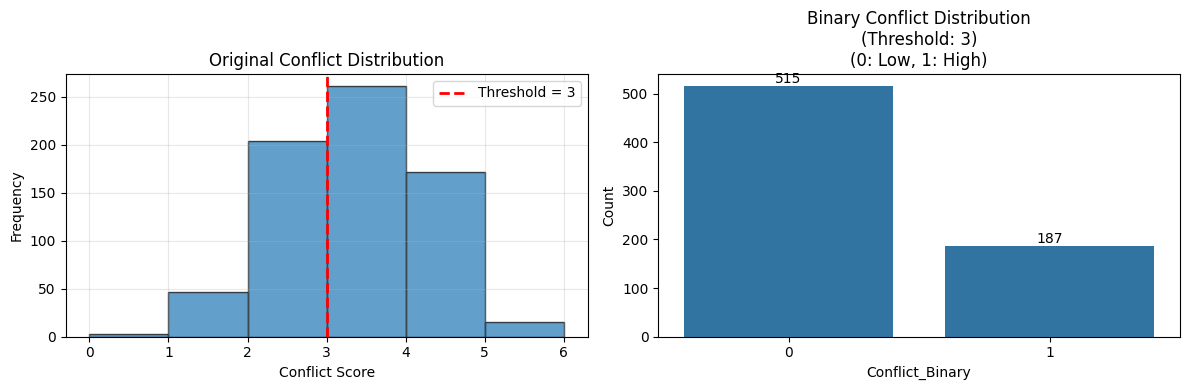

In [5]:
# create target variable using create_binary_conflict
df_data, results = create_binary_conflict(df_data, target_column='Conflicts', threshold=3, visualize=True)
   

# Test train split
- The train split is used for the modeling part.
- The test split is not involved in the modeling phase.

In [6]:
# split the data into train and test
from sklearn.model_selection import train_test_split

drop_cols = ['Student_ID', 'Addicted_Score', 'Conflict_Binary']

X_train_full, X_test, y_train_full, y_test = train_test_split(df_data.drop(columns=drop_cols), df_data['Conflict_Binary'], test_size=0.2, random_state=42)

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

X_train_full.head()

Train set shape: (561, 11)
Test set shape: (141, 11)
Train set shape: (561, 11)
Test set shape: (141, 11)


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts
166,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single,3
546,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship,4
285,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship,3
362,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single,3
111,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship,3


In [7]:
# Train/Validation Split (from the remaining 80%)
# → 60% train, 20% validation, 20% test overall
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

# Preprocessing Pipeline

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression



In [17]:
# ===============================
# 3. Define Column Groups
# ===============================
binary_cats       = ['Gender']         # boolean → 0/1
low_card_cols     = ['Relationship_Status', 'Academic_Level']                # few categories
high_card_cols    = ['Platform']                      # group rare then OHE
country_col       = ['Country']                                 # map to continent
numeric_cols      = df_data.drop(columns=drop_cols).select_dtypes(include=['number']).columns

from utils import continent_dict
# Example continent mapping dictionary


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from utils import RareCategoryGrouper, CountryToContinentMapper


# Boolean → int
binary_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Low-cardinality One-Hot
low_card_transformer = OneHotEncoder(handle_unknown='ignore')

# High-cardinality grouping + One-Hot
high_card_transformer = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=30)),
    ('onehot',    OneHotEncoder(handle_unknown='ignore'))
])

# Country → Continent → One-Hot
country_transformer = Pipeline([
    ('map_continent', CountryToContinentMapper(mapping=continent_dict)),
    ('onehot',        OneHotEncoder(handle_unknown='ignore'))
])

# Numeric scaling
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

Transformed feature matrix (first 5 rows):
   Gender_Male  Relationship_Status_Complicated  \
0          0.0                              0.0   
1          1.0                              0.0   
2          0.0                              0.0   
3          1.0                              0.0   
4          0.0                              0.0   

   Relationship_Status_In Relationship  Relationship_Status_Single  \
0                                  1.0                         0.0   
1                                  1.0                         0.0   
2                                  1.0                         0.0   
3                                  0.0                         1.0   
4                                  1.0                         0.0   

   Academic_Level_Graduate  Academic_Level_High School  \
0                      0.0                         0.0   
1                      1.0                         0.0   
2                      1.0                         0.0 

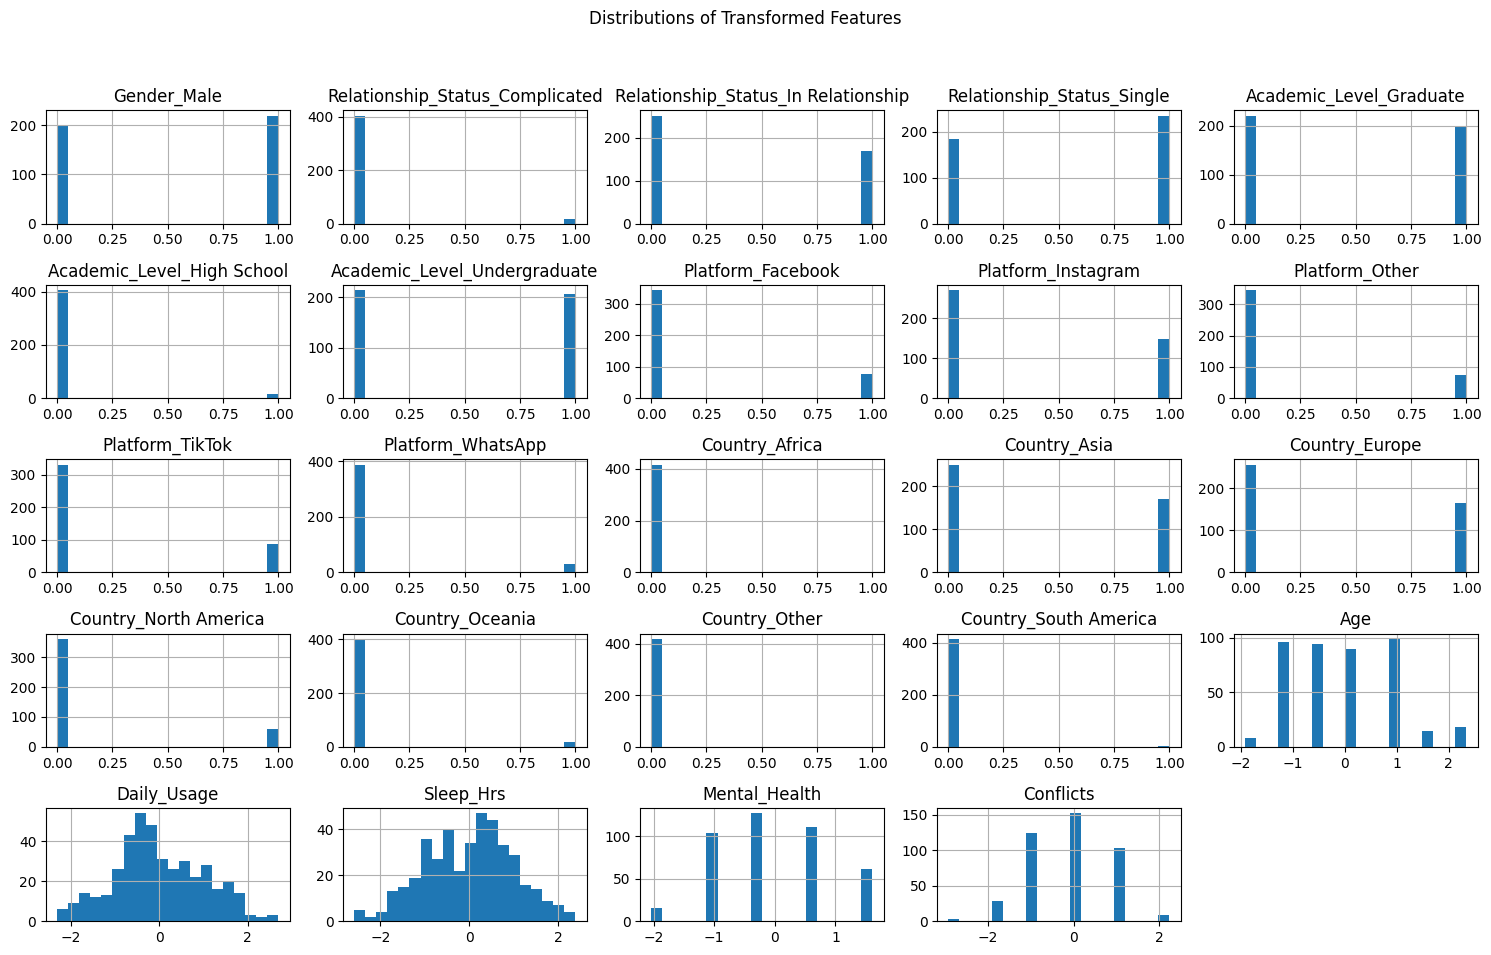

In [11]:
# ===============================
# Apply preprocessing and inspect transformed features
# ===============================
from scipy import sparse

from sklearn.pipeline import Pipeline

# 1. Fit the preprocessing step on the training data
# preprocessor = pipeline.named_steps['preprocessing']
preprocessor.fit(X_train)

# 2. Transform the training data
X_train_proc = preprocessor.transform(X_train)

# 3. Retrieve the transformed feature names
# 3. Manually build feature names list
feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'drop' or name == 'remainder':
        continue
    # If it's a Pipeline, get the final step
    if isinstance(transformer, Pipeline):
        last_step = transformer.steps[-1][1]
        if hasattr(last_step, 'get_feature_names_out'):
            names = last_step.get_feature_names_out(cols)
        else:
            # fallback: use input col names
            names = cols
    else:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            # fallback to the original column names
            names = cols
    feature_names.extend(names)

# 4. Convert to DataFrame (densify if sparse)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)

# 5. Print the first few rows
print("Transformed feature matrix (first 5 rows):")
print(X_train_df.head())

# 6. Simple visualization: histograms for each feature
X_train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Transformed Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Classification pipeline: baseline model

In [12]:
# 2. Build a baseline pipeline
baseline_pipeline = Pipeline([
    ("preprocessing", preprocessor),                      # your preprocessor from earlier
    ("classifier", DummyClassifier(strategy="most_frequent"))
])

In [ ]:
# import mlflow

import mlflow.sklearn
import mlflow.data
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from mlflow.models.signature import infer_signature
import numpy as np
import mlflow.data
from mlflow.data.pandas_dataset import PandasDataset
import warnings
from sklearn.exceptions import UndefinedMetricWarning


# 1. Create Dataset objects for each split
train_ds = mlflow.data.from_pandas(
    df=X_train,
    source="../data/data_cleaned.pickle",
    name="social_sphere_train_v1"
)
val_ds = mlflow.data.from_pandas(
    df=X_val,
    source="../data/data_cleaned.pickle",
    name="social_sphere_val_v1"
)
test_ds = mlflow.data.from_pandas(
    df=X_test,
    source="../data/data_cleaned.pickle",
    name="social_sphere_test_v1"
)

# 3. Train, evaluate, log, and register
with mlflow.start_run(run_name="baseline_dummy_majority"):
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    mlflow.log_input(train_ds,   context="training")
    mlflow.log_input(val_ds,     context="validation")
    mlflow.log_input(test_ds,    context="test")
    # Fit on training data
    baseline_pipeline.fit(X_train, y_train)

    # after fitting your pipeline:
    example_input = X_train.iloc[:5].copy()
    # Convert integer columns to float
    for col in example_input.select_dtypes(include=['int64']).columns:
        example_input[col] = example_input[col].astype('float')        
    signature = infer_signature(example_input, baseline_pipeline.predict(example_input))
    
    # Predict on validation set
    y_pred = baseline_pipeline.predict(X_val)
    y_proba = baseline_pipeline.predict_proba(X_val)[:, 1]
    
    # Compute metrics
    acc     = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1      = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    # Log parameters & metrics
    mlflow.log_param("strategy", "most_frequent")
    mlflow.log_metric("accuracy",    acc)
    mlflow.log_metric("precision",   precision)
    mlflow.log_metric("recall",      recall)
    mlflow.log_metric("f1_score",    f1)
    mlflow.log_metric("roc_auc",     roc_auc)
    mlflow.log_param("dataset_name", "social_media_behavior_v1")
    mlflow.log_param("dataset_version", "2025-06-14")  # or a git hash / DVC tag

    
    # Log classification report and confusion matrix as artifacts
    report_txt = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    # Save report to file and log
    with open("classification_report.txt", "w") as f:
        f.write(report_txt)
    mlflow.log_artifact("classification_report.txt")
    
    # Save confusion matrix image
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()
    
    # Log and register the model
    mlflow.sklearn.log_model(
        sk_model=baseline_pipeline,
        name="baseline_model",                 # instead of artifact_path
        registered_model_name="conflict_baseline_dummy",
        signature=signature,
        input_example=example_input
    )

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/cleaned_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/cleaned_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry

In [14]:
assert False

AssertionError: 